In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "."]).decode("utf8"))

House prices Exploratory Data Analysis.ipynb
test.csv
train.csv



In [7]:
%matplotlib inline
import numpy as np
import pandas as pd 
pd.set_option('precision', 3)

import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
print("test")

test


In [8]:
# set some display options
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

# read in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#what are we doing here? checking the types of columns
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [20]:
type(quantitative)
type(qualitative)

list

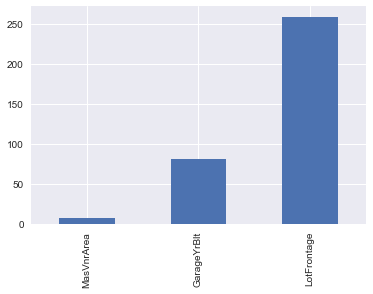

In [21]:
#let's figure out how much data is missing...

missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending=True)
missing.plot.bar()

In [12]:
#what do we know about missing?
#19 features missing. 5 of them missing more than half the data


In [3]:
import scipy.stats as st
y = train['SalePrice'] # this is what we are predicting
plt.figure(5); plt.title('Probability Plot of SalePrice')
res = stats.probplot(train['SalePrice'], plot=plt)
print("Our output variable does not appear to be normally distributed")

## let's graph the distribution of SalePrice, and fit it to a few differnt distributions.
# whichever provides the best fit we will transform
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

NameError: name 'train' is not defined

In [15]:
# now we should test normality of the predictive, quantitative variables.
pd.set_option('precision', 5)

# test_normality will return true if a column on the dataframe looks to be normal with the .01 cutoff according to stats.shapiro
# what is stats.shapiro?? tests the null hypothesis that data is drawn from a normal distribution
#returns a test statistic, and a p-value
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] > .01
## null hypothesis is normal. if 
## returns true if you cannot reject the null hypothesis, and is normal

## if the p value is less than .01, then

normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
## normal is a Series containing the quantitative columns names, and a boolean if they can be considered normal as per the shapiro-wilk test
print("There is normal Data") if (normal.any()) else print("There is no normal quantitative predictor variable data \n")

There is no normal quantitative predictor variable data 



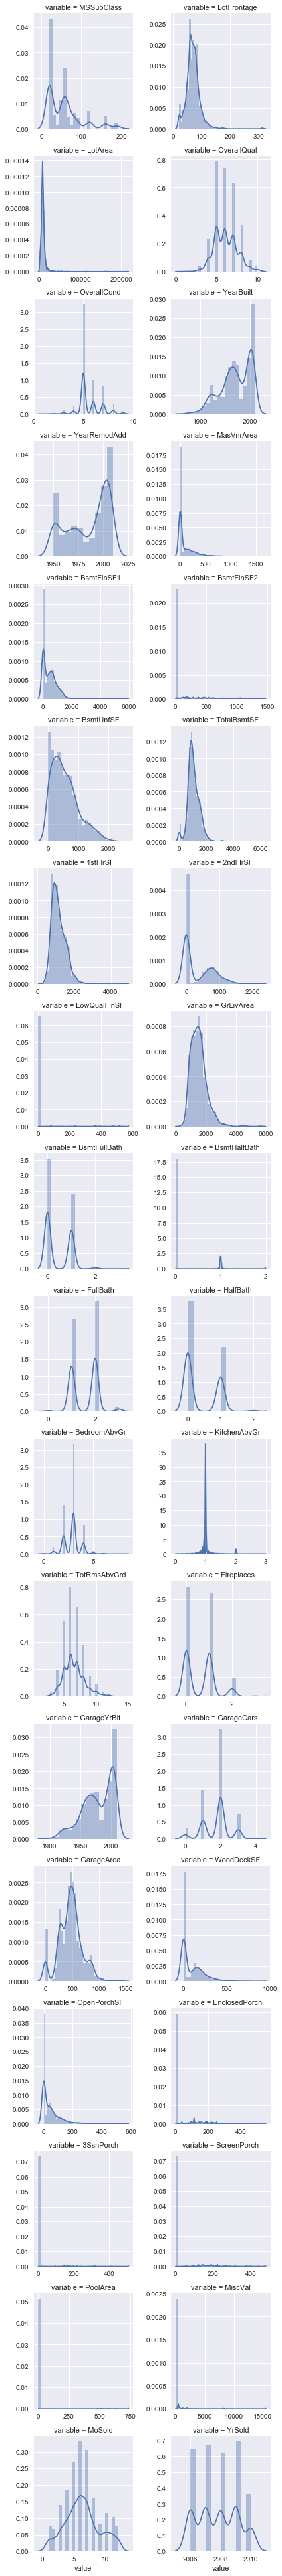

In [16]:
# let's test the distribution of our quantitative predictive variables
## something with melt... how do we figure this out??
f = pd.melt(train, value_vars=quantitative) ## put values for all columns into one column.
#then, put the source variable into the variable column
# we want to plot all of these graphs at once. 
# let's parse the data into this facetGrid
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
# col = 'variable' defines the variables that will go in the individual boxes
g = g.map(sns.distplot, "value")

In [17]:
## now it's time to analyze the categorial stuff - let's see how they might correlate with SalePrice
## for now, we
for c in qualitative: 
    train[c] = train[c].astype('category') #train[c] is a Pandas Series
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')
    print("Categories for predictive variable " + c + ": ")
    print(train[c].cat.categories.tolist()) 

Categories for predictive variable MSZoning: 
['C (all)', 'FV', 'RH', 'RL', 'RM']
Categories for predictive variable Street: 
['Grvl', 'Pave']
Categories for predictive variable Alley: 
['Grvl', 'Pave', 'MISSING']
Categories for predictive variable LotShape: 
['IR1', 'IR2', 'IR3', 'Reg']
Categories for predictive variable LandContour: 
['Bnk', 'HLS', 'Low', 'Lvl']
Categories for predictive variable Utilities: 
['AllPub', 'NoSeWa']
Categories for predictive variable LotConfig: 
['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside']
Categories for predictive variable LandSlope: 
['Gtl', 'Mod', 'Sev']
Categories for predictive variable Neighborhood: 
['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
Categories for predictive variable Condition1: 
['Artery', 'Feedr', 'Norm', 'PosA', 'P

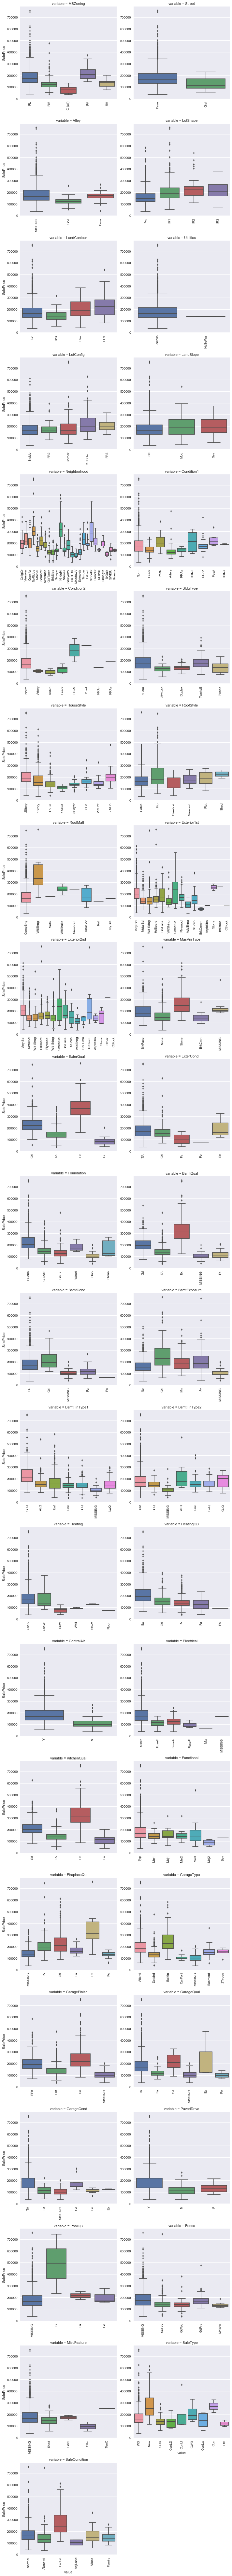

In [18]:
## now let's graph the frequency of each category
## looks like we want to customize each individual graph

def boxplot(x, y, **kwargs): ## custom boxplot function...
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative) ## melt columns for use in facetgrid
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g.map(boxplot, "value", "SalePrice")

### challenge to myself - can i make these graphs by iterating through the columns in quantitative??

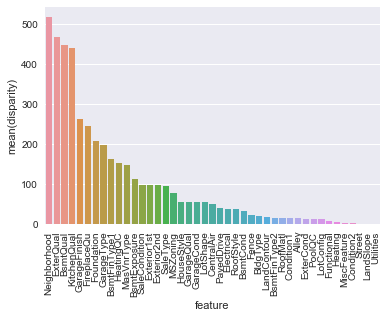

In [29]:
## let's analyze how each categorical variable influences the variance of the predictive variable
## the null hypothesis in ANOVA is that each of the variables has the same population mean
## we want to see if this holds true amongst the categories
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative ## make a row for each qualitative eature
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique(): ## iterate through each type of the feature
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
            ## get a list of lists of all the values for each category
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values) ## calculates a metric. the higher the metric, 
                                             ## the more impact the categorical variables have on  the outcome
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.


In [44]:
## now we want to sort the sub_features by their influence on the mean house price
## we willl add new columns, {cat}_E, with the value ordered respectively
## would it work to normalize this from 0 to 1 with the effect? 
## thoughts...
## "Now qualitative variables get encoded according to ordering based on mean of SalePrice.
""

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    #print (ordering)
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    #print(ordering.items())
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o 
    
qual_encoded = []
for q in qualitative:  
    #print("Encoding variable:", q)
    encode(train, q)
    qual_encoded.append(q+'_E')
    

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,1,60,RL,65.0,8450,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
1,2,20,RL,80.0,9600,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
2,3,60,RL,68.0,11250,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
3,4,70,RL,60.0,9550,Pave,MISSING,IR1,Lvl,AllPub,...,3.0,2.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,2.0
4,5,60,RL,84.0,14260,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0


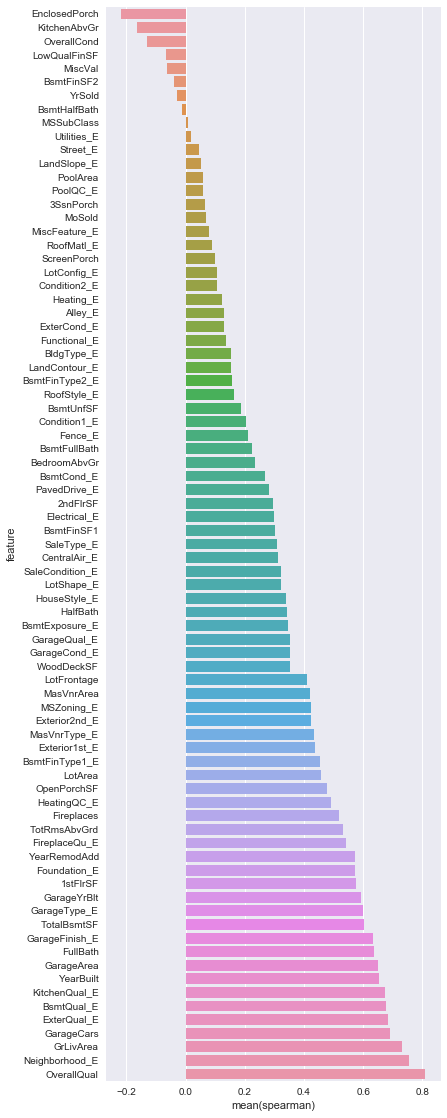

In [46]:
## now w're going to try to figure out which categorical variables to add.
## don't want overly correlated variables 

## spearman's correlation value -> why are we using this over the standard correlation metrics??
## pearson (standard) measures linear correlation. spearman's computes monotonic correlation
## monotonic might be better for these ordered categorical variables
## spearman is good for orginals

def spearman(frame, features):
    spr = pd.DataFrame() ## new dataframe for the spr results for each feature, quantitative and encoded qualitative
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

##Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.



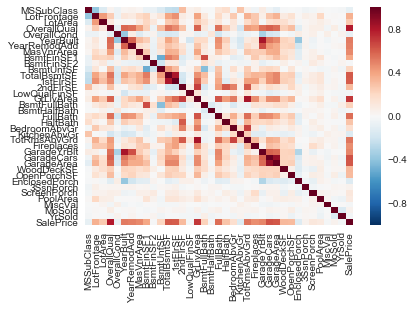

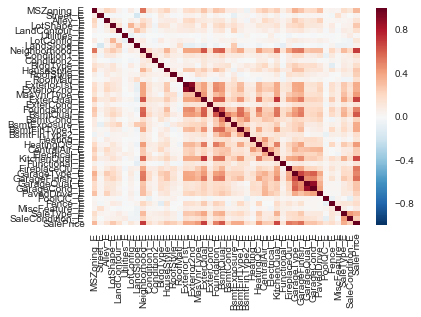

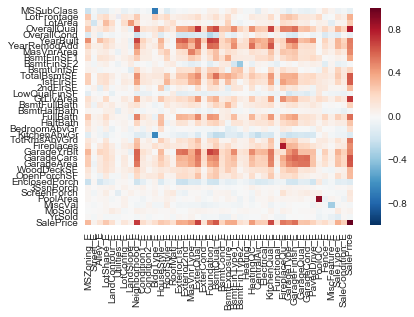

In [57]:
## let's get the standard correlation matrics for quantitative variables
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)

## let's get it for encoded categorical variables
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)

## now let's correlate quantitative and categorical together
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
corr.head(50)
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)


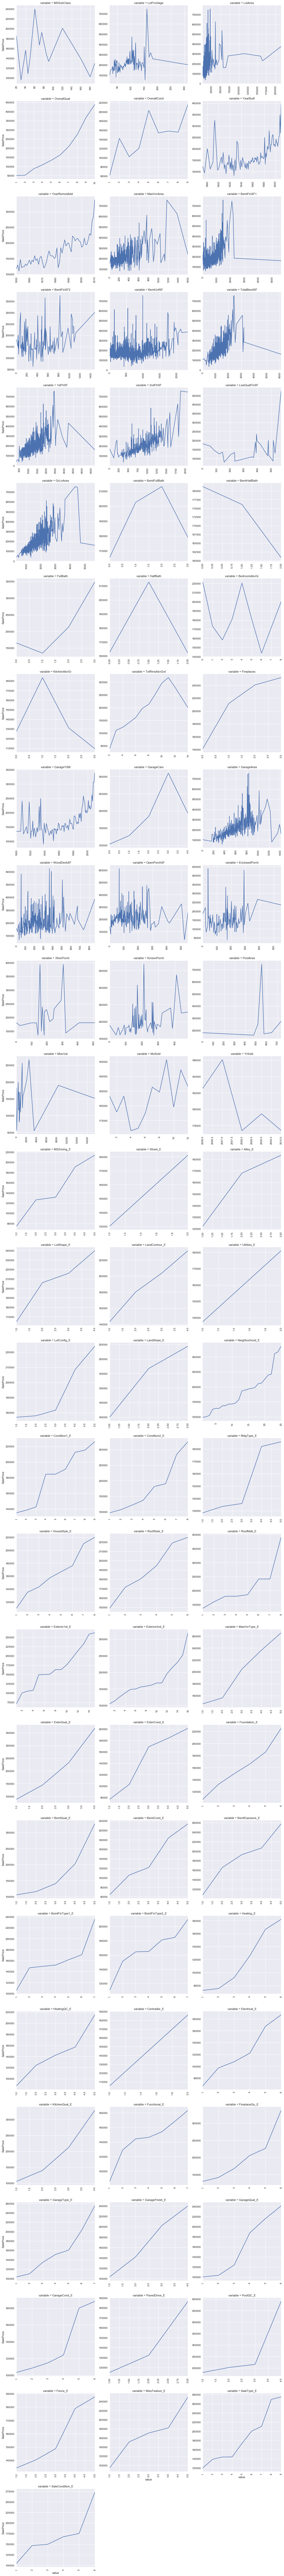

In [66]:
## we want to analyze the correlation between each independent variable
## and saleprice

def pairplot(x, y, **kwargs):
    ax = plt.gca() ## initialize a matplotlib axes object
    ts = pd.DataFrame({'x': x, 'val': y})
    ts = ts.groupby('x').mean() ## we want a single value for each X, set as the mean of SalePrice
    ts.plot(ax=ax) ## plot it on the axes
    plt.xticks(rotation=90) ## rotate the axes
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

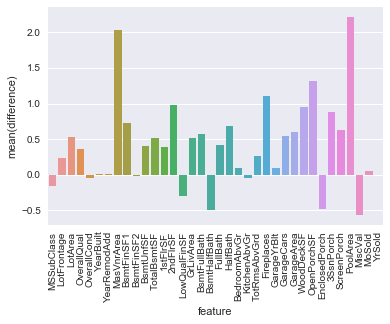

In [70]:
#Price Segmentations
# how can you segment the y variable?

features = quantitative

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

0.754416165856


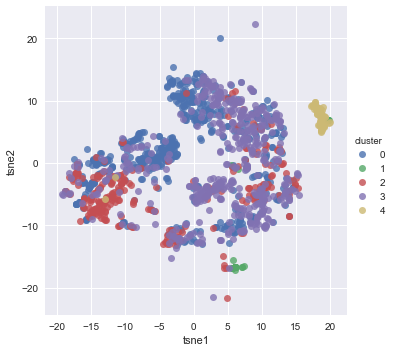

In [80]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

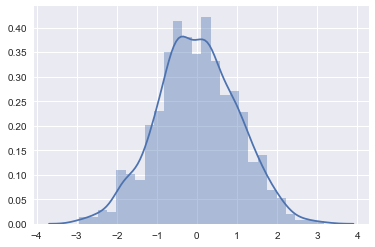

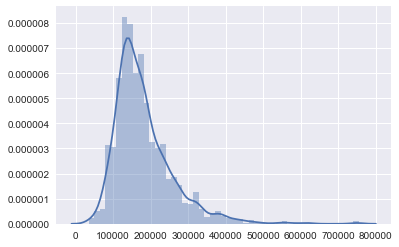

In [77]:
y = train['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

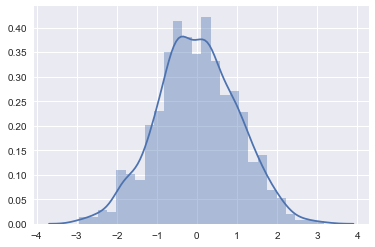

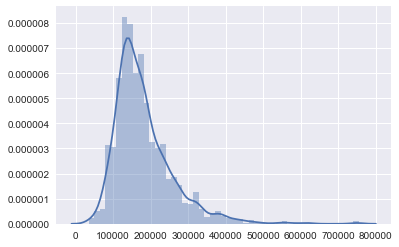

In [78]:
y = train['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

In [79]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

0.11263269017843167